In [1]:
# Sample the kinegeometric distance posterior - an outline
# CBJ Feb. 2024
# Work in units of kpc, km/s, mas, and mas/yr.

In [2]:
import numpy as np
from scipy.special import gamma, factorial, loggamma
from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
import emcee # https://emcee.readthedocs.io/en/stable/
# Other possible samplers:
# https://pymcmcstat.readthedocs.io/en/latest/
# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/MetropolisHastings
# https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html - old

import rpy2
from rpy2.robjects.packages import importr, data
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects import r

numpy2ri.activate() #activate conversion from R-code to numpy arrays
from astroquery.gaia import Gaia
import math
from zero_point import zpt # need to install gaiadr3-zeropoint
zpt.load_tables()

from metropolis import metrop
from functions import mode_post3 
from scipy import integrate


R[write to console]: data.table 1.13.6 using 12 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Lade nötiges Paket: bit

R[write to console]: 
Attache Paket: ‘bit’


R[write to console]: The following object is masked from ‘package:data.table’:

    setattr


R[write to console]: The following object is masked from ‘package:base’:

    xor


R[write to console]: Attaching package bit64

R[write to console]: package:bit64 (c) 2011-2017 Jens Oehlschlaegel

R[write to console]: creators: integer64 runif64 seq :

R[write to console]: coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bitstring

R[write to console]: logical operator: ! & | xor != == < <= >= >

R[write to console]: arithmetic operator: + - * / %/% %% ^

R[write to console]: math: sign abs sqrt log log2 log10

R[write to console]: math: floor ceiling trunc round

R[write to console]: querying: is.integer64 is.vector [is.atomic} [length] format print str

R[write t

In [3]:
# Constants
kfac = 4.740471 # vel[km/s] = kfac * r[kpc] * propm[mas/yr]
# seed
seed = 123
np.random.seed(seed)

In [4]:
# Define functions

# Return the mean (meanTau) [1/(km/s)] and covariance (CovTau) [1/(km/s)^2]
# of the velocity prior 
# Sourced from R-file: call_velocity_prior.R
r_source2 = robjects.r['source']
r_source2('./Rfiles/call_velocity_prior.R')
kinegeo_prior_stats = robjects.globalenv['eval.prior.healpix']

def velpriorparams(dist, healpix):
    # Return the mean (meanTau) [1/(km/s)] and covariance (CovTau) [1/(km/s)^2]
    # of the velocity prior 
    
    vramean_tau, vrasd_tau, vdecmean_tau, vdecsd_tau, cor_tau = kinegeo_prior_stats(p=healpix,r=dist*1e3)  # output is in km/s, takes input in pc
    
    meanTau = np.array([vramean_tau,vdecmean_tau])
    CovTau = np.array([[vrasd_tau**2 ,vrasd_tau * vdecsd_tau *cor_tau], 
                       [vrasd_tau*vdecsd_tau*cor_tau,vdecsd_tau**2]])
    
    return meanTau , CovTau

def logdistpriordensity(dist, alpha,beta,rlen):
    # Return log (base 10) of the unnormalized distance prior [1/kpc]
    
    # convert rlen from pc to kpc 
    rlen = rlen*1e-3

    #dist = np.where(dist > 0,dist,0)
    #prior = 1/(gamma((beta+1)/alpha)) * alpha/(rlen**(beta+1)) * dist**beta * np.exp(-((dist/rlen)**alpha))
    #logPrior = np.log10(prior)
    logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
    
    return 0.4342945*logPrior

def logparallaxlikelihood(dist, parallax, parallaxVar):
    # Return log (base 10) of the (normalized) likelhood of the parallax at this distance.
    # parallaxVar is the relevant element of the Cov3 matrix.
    # This is a simple 1D Gaussian density.
    return 0.4342945* mvn.logpdf(parallax,mean=1/dist,cov=parallaxVar)
    
    
def loggeopostdensity(dist, parallax, parallaxVar, alpha,beta,rlen):
    # Return the log (base 10) of the unnormalized density of the geometric distance 
    # posterior [1/kpc]  
    # logparallaxlikelihood + logdistpriordensity
    
    result = logparallaxlikelihood(dist=dist, parallax=parallax, parallaxVar=parallaxVar)\
    + logdistpriordensity(dist=dist,alpha=alpha,beta=beta,rlen=rlen)

    #if dist > 0:     
    #    result =  logparallaxlikelihood(dist=dist, parallax=parallax, parallaxVar=parallaxVar)\
    #    + logdistpriordensity(dist=dist,alpha=alpha,beta=beta,rlen=rlen)
    #else: 
    #    result = -np.inf

    return result

    
def logQfunc(dist, parallax, propm, Cov3, Cov2, kfac,healpix, meanTau, CovTau):
    """
    Implements Equation 8d
    In principle we only need the inverse of a covariance matrix to compute
    an unnormalized Gaussian, in which case we could just pass invCov2 and would
    not need Cov2. But scipy.stats.multivariate_normal doesn't seem to give this option.
    We could pass invCov2 to save inverting it for use in m_v and Cov_v, but it's only
    so just write it out explicitly.

    Parameters
    ----------
    dist:      distance [kpc] scalar
    parallax:  parallax [mas] scalar
    promp:     proper motion [mas/yr] 2-element vector
    Cov3:      full data astrometric covariance matrix [various] 3x3 matrix
    Cov2:      partial data covariance matrix [(mas/yr)^2] 2x2 matrix
    CovTau:    velocity prior covariance matrix [(km/s)^2] 2x2 matrix
    kfac:      constant

    Returns
    -------
    Log (base 10) density of Q(r,parallax,promp)
    """
    
    # Compute the inverse of Cov2 (equation 4b)
    # Compute X_mu (equation 4a)
    # Call velpriorparams() to get meanTau and CovTau
    # Invert CovTau
    # Compute logdensity of Q using scipy.stats.multivariate_normal.logpdf
    # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html
    # - don't forget to multiply by kfac*dist to get Q.
     
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_w = Cov3[0,0]
    
    X_mu = Sigma_mu_w * Sigma_w_w**(-1) * (parallax-1/dist)
    
    
    
    logN = 0.4342945* mvn.logpdf(x=meanTau,mean=kfac*dist*(propm-X_mu),cov=kfac**2 * dist**2 * Cov2 + CovTau)
    
    return np.log10(kfac*dist) + logN
    
def logkinegeopostdensity(dist, parallax, parallaxVar ,propm, Cov3, Cov2, healpix, alpha,beta,rlen, kfac):
    # Return the log (base 10) of the (unnormalized) density of the kinegeometric 
    # distance posterior [1/kpc]  
    # logQfunc + loggeopostdensit
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    
    result = logQfunc(dist=dist, parallax=parallax, propm=propm, Cov3=Cov3, Cov2=Cov2, kfac=kfac,healpix=healpix, meanTau=meanTau, CovTau=CovTau)\
        + loggeopostdensity(dist=dist, parallax=parallax, parallaxVar=parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    
    #if dist > 0:     
    #    result = logQfunc(dist=dist, parallax=parallax, propm=propm, Cov3=Cov3, Cov2=Cov2, kfac=kfac,healpix=healpix, meanTau=meanTau, CovTau=CovTau)\
    #    + loggeopostdensity(dist=dist, parallax=parallax, parallaxVar=parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    #
    #else: 
    #    result = -np.inf

    return result

## Test kinegeo distance estiamte for one source 

In [5]:
# Define data: parallax, prompm, Cov3 (equation 2)
# The parallax should be zero-point corrected.
# Compute (once) Cov2 (equation 4b)

source_id = 3490291841517005824

job = Gaia.launch_job("select top 10 "
                                        "source_id, parallax, parallax_error,\
                                        phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour,\
                                        ecl_lat, astrometric_params_solved,bp_rp,pmra,pmra_error,\
                                        pmdec, pmdec_error,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr "
                                        "from gaiadr3.gaia_source "
                                        "where source_id={}".format(int(source_id)))
r = job.get_results()

w = float(r['parallax'])
sd_w = float(r['parallax_error'])   

mu_ra = float(r['pmra'])
mu_dec = float(r['pmdec'])
sd_mu_ra = float(r['pmra_error'])
sd_mu_dec = float(r['pmdec_error'])
corr_w_mu_ra = float(r['parallax_pmra_corr'])
corr_w_mu_dec = float(r['parallax_pmdec_corr'])
corr_mu_ra_dec = float(r['pmra_pmdec_corr'])

phot_g_mean_mag = float(r['phot_g_mean_mag'])
nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'])
pseudocolour = float(r['pseudocolour'])
ecl_lat = float(r['ecl_lat'])
astrometric_params_solved = float(r['astrometric_params_solved'])


source_id = int(r['source_id'])
healpix = math.floor(source_id / (2**(35)*4**(12-5)) )

# zeropoint correction
if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
    if  phot_g_mean_mag == np.nan:
        wzp = -0.017                    
    else:
         wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
else: 
    wzp = 0

parallax = w - wzp

parallaxVar = sd_w**2

propm = np.array([mu_ra,mu_dec])

Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                 [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                 [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])


Sigma_w_w = Cov3[0,0]
Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                       [Cov3[2,1],Cov3[2,2]]])



Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w,np.dot(Sigma_w_w**(-1),Sigma_w_mu))


print('\033[1m' + f'Data for Gaia DR3 {source_id}: ' + '\033[0m')
print('')
print('HEALpixel level 5:',healpix)
print('parallax [mas]',w)
print('Zeropoint [mas]', wzp)
print('Zeropointcorrected parallax w[mas]',parallax)
print('proper motion ra [mas/yr]:',mu_ra)
print('proper motion dec [mas/yr]:',mu_dec)
print('proper motion ra error [mas/yr]:',sd_mu_ra)
print('proper motion dec error [mas/yr]:',sd_mu_dec)
print('parallax - proper motion ra correlation: ',corr_w_mu_ra)
print('parallax - proper motion dec correlation: ',corr_w_mu_dec)
print('proper motion ra-dec correlation: ',corr_mu_ra_dec)



Data for Gaia DR3 3490291841517005824: 

HEALpixel level 5: 6200
parallax [mas] -0.3773184234931663
Zeropoint [mas] 0.037905
Zeropointcorrected parallax w[mas] -0.4152234234931663
proper motion ra [mas/yr]: 2.0912555155607677
proper motion dec [mas/yr]: -1.9428565253351533
proper motion ra error [mas/yr]: 1.0018446445465088
proper motion dec error [mas/yr]: 0.6796760559082031
parallax - proper motion ra correlation:  -0.10427084565162659
parallax - proper motion dec correlation:  -0.06963025778532028
proper motion ra-dec correlation:  -0.14000561833381653


/tmp/ipykernel_3664259/744462000.py:28: UserWarning: Warning: converting a masked element to nan.
  nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'])
/Home/no233/linux/.local/lib/python3.9/site-packages/zero_point/zpt.py:233: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  warnings.warn(


In [6]:
# Sample logkinegeopostdensity 
# Use an MCMC package. You may need a wrapper function to logkinegeopostdensity so that
# it's argument and return(s) are in the right order/format for the MCMC function.
# Try your Metropolis first.
# Later: maybe try emcee. Probably 4-8 walkers is enough. We'll need to experiment to determine
# how much burnin and how many samples, but I expect around 20-50 and 50-100 is enough
# (depending on the number of walkers). Try initializing the walkers close to the
# median of the geometric posterior, with a standard deviation equal to the (robust)
# standard deviation of that that posterior.

# For testing purposes, you should also directly compute a few different posteriors
# on a dense grid , so as to compare the "true" distribution.

# used mode of EDSD-posterior to initialize metrop algorithm, transform to kpc

Nsamp= 500
Nburnin= 50

rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)

alpha = float(rows_prior_summary[healpix][6])
beta = float(rows_prior_summary[healpix][7])
rlen = float(rows_prior_summary[healpix][5])
    
rlen_EDSD = float(rows_prior_summary[healpix][10])
rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
rStep = 0.75*rInit*min(1/3, abs(sd_w/parallax))

#geometric samples
samp_geo = metrop(func=loggeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed,parallax=parallax, parallaxVar = parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
rSamp_geo = samp_geo[:,1]

#kinegeometric samples
samp_kinegeo = metrop(func=logkinegeopostdensity ,thetaInit= rInit, Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed,parallax=parallax, parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix,alpha=alpha,beta=beta,rlen=rlen, kfac=kfac)
rSamp_kinegeo = samp_kinegeo[:,1]



/tmp/ipykernel_3664259/2849474582.py:31: RuntimeWarning: invalid value encountered in log
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_3664259/2849474582.py:31: RuntimeWarning: invalid value encountered in power
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha


### Alternatively: sample using emcee

In [7]:
#Nsamp= 500
#Nburnin= 50
#ndim = 1
#nwalkers = 5
#
## geometric samples
#p0_geo = np.random.uniform(low=0.75*rInit, high=1.25*rInit, size=(nwalkers,1)) # initialisatzion: random value between 0.75 and 1.25 * mode of geometric posterior
#sampler_geo = emcee.EnsembleSampler(nwalkers, ndim, loggeopostdensity, args=[parallax, parallaxVar, alpha,beta,rlen])
#
#state_geo = sampler_geo.run_mcmc(p0_geo, Nburnin)
#sampler_geo.reset()
#
#sampler_geo.run_mcmc(state_geo, Nsamp)
#
#samp_geo = sampler_geo.get_chain(flat=True)
##plt.hist(samp_geo, 50, color="k", histtype="step")
#rSamp_geo = samp_geo.flatten()
#
#
## kinegeometric samples
#
##p0 = np.random.normal(loc=np.median(rSamp_geo), scale=np.std(rSamp_geo),size=(nwalkers,1))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, logkinegeopostdensity, args=[parallax, parallaxVar ,propm, Cov3, Cov2, healpix,alpha,beta,rlen, kfac])
#
#state = sampler.run_mcmc(p0_geo, Nburnin)
#sampler.reset()
#
#sampler.run_mcmc(state, Nsamp)
#
#samp = sampler.get_chain(flat=True)
##plt.hist(samp, 50, color="k", histtype="step")
#
#rSamp = samp.flatten()

Distance estimation:

MCMC initialization [pc]: 1.4449809723728524
MCMC stepsize [pc]: 0.36124524309321304
MCMC number of burn-in samples: 50
MCMC number of retained iterations: 500

Kinegeometric distance:

estimated distance [pc] (quantile 0.5): 2.5433029373876366
lower distance limit [pc] (quantile 0.159): 1.6181373717018992
upper distance limit [pc] (quantile 0.841): 3.623857230440003

Geometric distance:

estimated distance [pc] (quantile 0.5): 2.316145850384091
lower distance limit [pc] (quantile 0.159): 1.409215219362129
upper distance limit [pc] (quantile 0.841): 3.5957668517666166



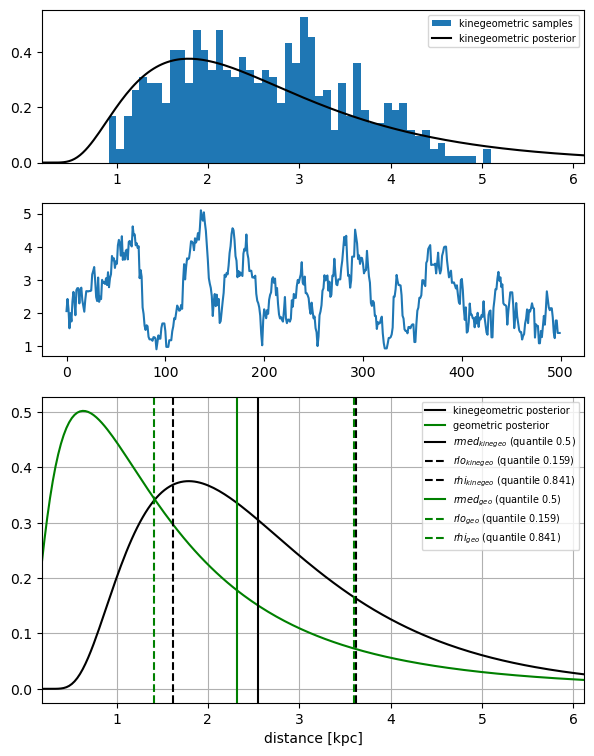

In [8]:
# Plots
fig,ax = plt.subplots(3,1,figsize=(7,9), gridspec_kw={'height_ratios': [1,1,2]})

# distance range for plotting
rplotlo = 0.2*min(rSamp_kinegeo)
rplothi = 1.2*max(rSamp_kinegeo)

r_plot = np.linspace(rplotlo,rplothi,200)

# plot histogram of samples
ax[0].hist(rSamp_kinegeo,bins=50,density=True,label='kinegeometric samples')
ax[0].set_xlim(rplotlo,rplothi)

#plot chains
ax[1].plot(np.arange(0,len(rSamp_kinegeo),1),rSamp_kinegeo)

# plot kinegeo + geo posterior              
logKinegeo_plot=[]

for i in r_plot: 
    logKinegeo_plot.append(logkinegeopostdensity(i, parallax, parallaxVar ,propm, Cov3, Cov2, healpix,alpha,beta,rlen, kfac))

kinegeo_plot = 10**(np.array(logKinegeo_plot))         
kinegeo_norm = integrate.trapezoid(kinegeo_plot,r_plot)

geo_plot = 10**(loggeopostdensity(r_plot, parallax, parallaxVar, alpha,beta,rlen))
geo_norm = integrate.trapezoid(geo_plot,r_plot)


ax[2].plot(r_plot,kinegeo_plot/kinegeo_norm, label='kinegeometric posterior',color='k')
ax[0].plot(r_plot,kinegeo_plot/kinegeo_norm, label='kinegeometric posterior',color='k')

ax[2].plot(r_plot,geo_plot/geo_norm,label='geometric posterior',color='green')

ax[2].set_xlim(rplotlo,rplothi)
ax[2].set_xlabel('distance [kpc]')
ax[2].grid()

# get quantiles: 

probs = np.array([0.5,0.1586553,0.8413447])
rQuant_kinegeo = np.quantile(rSamp_kinegeo,probs)
rest_kinegeo = rQuant_kinegeo[0]
rlo_kinegeo = rQuant_kinegeo[1]
rhi_kinegeo = rQuant_kinegeo[2]

rQuant_geo = np.quantile(rSamp_geo,probs)
rest_geo = rQuant_geo[0]
rlo_geo = rQuant_geo[1]
rhi_geo = rQuant_geo[2]


ax[2].axvline(rest_kinegeo,label ='$rmed_{kinegeo}$ (quantile 0.5)',color='k')
ax[2].axvline(rlo_kinegeo,linestyle='--',label ='$rlo_{kinegeo}$ (quantile 0.159)',color='k')
ax[2].axvline(rhi_kinegeo,linestyle='--',label ='$rhi_{kinegeo}$ (quantile 0.841)',color='k')

ax[2].axvline(rest_geo,label ='$rmed_{geo}$ (quantile 0.5)',color='green')
ax[2].axvline(rlo_geo,linestyle='--',label ='$rlo_{geo}$ (quantile 0.159)',color='green')
ax[2].axvline(rhi_geo,linestyle='--',label ='$rhi_{geo}$ (quantile 0.841)',color='green')

ax[2].legend(fontsize=7)
ax[0].legend(fontsize=7)


print('\033[1m' + 'Distance estimation:' + '\033[0m')
print('')
print('MCMC initialization [pc]:', rInit)
print('MCMC stepsize [pc]:',rStep)
print('MCMC number of burn-in samples:',Nburnin)
print('MCMC number of retained iterations:',Nsamp)
print('')
print('Kinegeometric distance:')
print('')
print('estimated distance [pc] (quantile 0.5):',rest_kinegeo)
print('lower distance limit [pc] (quantile 0.159):', rlo_kinegeo)
print('upper distance limit [pc] (quantile 0.841):', rhi_kinegeo)
print('')
print('Geometric distance:')
print('')
print('estimated distance [pc] (quantile 0.5):',rest_geo)
print('lower distance limit [pc] (quantile 0.159):', rlo_geo)
print('upper distance limit [pc] (quantile 0.841):', rhi_geo)
print('')


In [9]:
# Other stuff only required for velocity posterior
def logvelpriordensity(vel, dist, healpix):
    # Return log (base 10) density of the velocity prior [1/(km/s)^2] using 
    # scipy.stats.multivariate_normal.logpdf
    # Call velpriorparams(dist, healpix)
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    N = mvn.pdf(x=vel,mean=meanTau,cov=CovTau)
    
    return np.log10(N)

def velpostparams(dist, parallax, Cov2, Cov3, propm, healpix, kfac): 
    # Return the mean (meanVel) [km/s] and covariance (CovVel) [km/s^2]
    # of the velocity posterior 
    
    meanTau, CovTau = velpriorparams(dist=dist, healpix=healpix)
    invCovTau = np.linalg.inv(CovTau)
    
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_w = Cov3[0,0]
    
    X_mu = Sigma_mu_w * Sigma_w_w**(-1) * (parallax - (1/dist))
    mean2 = propm + X_mu
    
    A = np.linalg.inv(kfac**2 * dist**2 * Cov2)
    
    CovVel = np.linalg.inv(A + invCovTau)

    meanVel = np.matmul(CovVel , np.matmul(A*kfac*dist, propm - X_mu )+np.matmul(invCovTau,meanTau))
    
    
    return meanVel, CovVel 


In [10]:
# sample n velocities and take the mean for each kinegeo distance sample

n = 10
Nsamp = len(rSamp_kinegeo)

totVelsamp = [] #mean of velocity samples for all distances
totMeanVel = [] #mean of velocity posterior for all distances 

for i in range(len(rSamp_kinegeo)): 
    
    meanVel, CovVel = velpostparams(dist=rSamp_kinegeo[i], parallax=parallax, Cov2=Cov2, Cov3=Cov3, propm=propm, healpix=healpix, kfac=kfac)
    velsamp = np.random.multivariate_normal(mean = meanVel, cov = CovVel,size = n)
    velsamp_mean = np.mean(velsamp, axis=0)
    totVelsamp.append(velsamp_mean)
    totMeanVel.append(meanVel)
    
    
totVelsamp = np.array(totVelsamp)
totMeanVel = np.array(totMeanVel)

#get results: mean and quantiles of v_ra and v_dec + correlation between array of v_ra and v_dec samples
    
raVel = np.quantile(totVelsamp[:,0], probs)
decVel = np.quantile(totVelsamp[:,1], probs)
corrVel = np.corrcoef(totVelsamp[:,0], totVelsamp[:,1])

# Expectation value of velocity
    
E_v = 1/Nsamp * sum(totMeanVel)

#covariance between each velocity and distance

r_mean = 1/Nsamp * sum(rSamp_kinegeo)

Cov_rv_ra = 1/Nsamp * sum((rSamp_kinegeo-r_mean)*(totMeanVel[:,0]-E_v[0]))
Cov_rv_dec = 1/Nsamp * sum((rSamp_kinegeo-r_mean)*(totMeanVel[:,1]-E_v[1]))



In [11]:
#print summary statistics: 
print('\033[1m' + 'Velocity estimation:' + '\033[0m')
print('')
print('Number of velocity samples drawn for reach of the MCMC distance samples: ',n)
print('')
print('Estimated velocities:')
print('')
print('velocity in ra:')
print('estimated velocity [km/s] (quantile 0.5): ', raVel[0])
print('lower velocity limit [km/s] (quantile 0.159): ',raVel[1])
print('upper velocity limit [km/s](quantile 0.841): ',raVel[2])
print('')
print('velocity in dec:')
print('estimated velocity [km/s] (quantile 0.5): ', decVel[0])
print('lower velocity limit [km/s] (quantile 0.159): ',decVel[1])
print('upper velocity limit [km/s](quantile 0.841): ',decVel[2])
print('')
print('Correlation between v_ra and v_dec: ', corrVel[1,0])
print('')
print('Covariance between each velocity and distance:' )
print('Cov_rv_ra [kpc km/s]: ',Cov_rv_ra )
print('Cov_rv_dec [kpc km/s]: ',Cov_rv_dec )

Velocity estimation:

Number of velocity samples drawn for reach of the MCMC distance samples:  10

Estimated velocities:

velocity in ra:
estimated velocity [km/s] (quantile 0.5):  18.230532514216527
lower velocity limit [km/s] (quantile 0.159):  12.556443041927622
upper velocity limit [km/s](quantile 0.841):  26.840122257850403

velocity in dec:
estimated velocity [km/s] (quantile 0.5):  -22.702597766008957
lower velocity limit [km/s] (quantile 0.159):  -31.868116177663484
upper velocity limit [km/s](quantile 0.841):  -14.569282953439131

Correlation between v_ra and v_dec:  -0.7913074487562735

Covariance between each velocity and distance:
Cov_rv_ra [kpc km/s]:  5.022507878684071
Cov_rv_dec [kpc km/s]:  -6.879371822069889


## Compare to 3D sampling

### 1. Compare distance estimation results of 1000 stars of hp 6200

In [24]:
# Read in comparison data 

# array containing source_ids 
id_distvel_6200 = np.genfromtxt('distvel_6200.csv', delimiter=',', skip_header=1,  dtype='int64', usecols=0)
# array containig all data (dont use source_id from this, because its rounded, instead use array above)
data_distvel_6200 =  np.genfromtxt('distvel_6200.csv', delimiter=',', skip_header=1,  dtype='float64')

# remove all rows containing nan: 
comp_data = data_distvel_6200[~np.isnan(data_distvel_6200).any(axis=1), :][:100]
comp_source_ids = id_distvel_6200[~np.isnan(data_distvel_6200).any(axis=1)][:100]

#extract data from Gaia 

source_ids_string = ", ".join(map(str, comp_source_ids))
job = Gaia.launch_job("select "
                                            "source_id, parallax, parallax_error,phot_g_mean_mag,\
                                            nu_eff_used_in_astrometry, pseudocolour,\
                                            ecl_lat, astrometric_params_solved,bp_rp,\
                                            pmra,pmra_error,pmdec, pmdec_error,parallax_pmra_corr,\
                                            parallax_pmdec_corr,pmra_pmdec_corr "
                                            "from gaiadr3.gaia_source "
                                            "where source_id in ({})".format(source_ids_string))
r = job.get_results()



In [25]:
# sample posterior for each source 

rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)

rSamples_kinegeo = []
rSamples_geo = []

Nsamp= 1000
Nburnin= 100


for i in range(len(comp_source_ids[:])): 

    w = float(r['parallax'][i])
    sd_w = float(r['parallax_error'][i])   
    
    mu_ra = float(r['pmra'][i])
    mu_dec = float(r['pmdec'][i])
    sd_mu_ra = float(r['pmra_error'][i])
    sd_mu_dec = float(r['pmdec_error'][i])
    corr_w_mu_ra = float(r['parallax_pmra_corr'][i])
    corr_w_mu_dec = float(r['parallax_pmdec_corr'][i])
    corr_mu_ra_dec = float(r['pmra_pmdec_corr'][i])
    
    phot_g_mean_mag = float(r['phot_g_mean_mag'][i])
    nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][i])
    pseudocolour = float(r['pseudocolour'][i])
    ecl_lat = float(r['ecl_lat'][i])
    astrometric_params_solved = float(r['astrometric_params_solved'][i])
    
    
    source_id = int(r['source_id'][i])
    print(source_id)
    healpix = math.floor(source_id / (2**(35)*4**(12-5)) )
    
    # zeropoint correction
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
        if  phot_g_mean_mag == np.nan:
            wzp = -0.017                    
        else:
             wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
    else: 
        wzp = 0
    
    parallax = w - wzp
    parallaxVar = sd_w**2
    propm = np.array([mu_ra,mu_dec])
    
    Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                     [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                     [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])
    
    
    Sigma_w_w = Cov3[0,0]
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
    Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                           [Cov3[2,1],Cov3[2,2]]])
    
    
    
    Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w, Sigma_w_w**(-1)*Sigma_w_mu)
    
    
    alpha = float(rows_prior_summary[healpix][6])
    beta = float(rows_prior_summary[healpix][7])
    rlen = float(rows_prior_summary[healpix][5])
    rlen_EDSD = float(rows_prior_summary[healpix][10])
    
    rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
    rStep = 0.75*rInit*min(1/3, abs(sd_w/parallax))
    
    #kinegeometric samples
    samp_kinegeo = metrop(func=logkinegeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,parallax=parallax, seed=seed,parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix, alpha=alpha,beta=beta,rlen=rlen,kfac=kfac)
    rSamp_kinegeo = samp_kinegeo[:,1]
    rSamples_kinegeo.append(rSamp_kinegeo)
    
    #geometric samples
    samp_geo = metrop(func=loggeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed, parallax=parallax, parallaxVar = parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    rSamp_geo = samp_geo[:,1]
    rSamples_geo.append(rSamp_geo)
    
# save to csv file; all samples for one source_id are in one row, same order as input 

np.savetxt('./results/rSamples_kinegeo.csv', rSamples_kinegeo, delimiter=",")
np.savetxt('./results/rSamples_geo.csv', rSamples_geo, delimiter=",")

/tmp/ipykernel_3664259/4085315554.py:27: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'][i])


3490289711213205632


/tmp/ipykernel_3664259/4085315554.py:26: UserWarning: Warning: converting a masked element to nan.
  nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][i])


3490290123530068992
3490290608862052864
3490291326120920960
3490291841517005824


/tmp/ipykernel_3664259/2849474582.py:31: RuntimeWarning: invalid value encountered in log
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_3664259/2849474582.py:31: RuntimeWarning: invalid value encountered in power
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha


3490292533007404672
3490293800021157504
3490293907395889792
3490294319713737472
3490294624655815936
3490294659015547008
3490294938187716864
3490295311850583168
3490296617519698560
3490297205930652416
3490297235995008896
3490297339074223616
3490297412090193536
3490298133644704512
3490298339803133440
3490298717759354496
3490299473673786624
3490299748552465920
3490300229588804096
3490301599681814528


/tmp/ipykernel_3664259/2849474582.py:100: RuntimeWarning: invalid value encountered in log10
  return np.log10(kfac*dist) + logN


3490302493037031552
3490302737849711744
3490302978367100416
3490303798705072000
3490303833064810496
3490304284036964736
3490304455835276160
3490305177390349184
3490305658426683776
3490306036384596352
3490306551779691520
3490306753642624128
3490307131599775872
3490307135895082240
3490307853154150912
3490309124464500608
3490309330622932992
3490309644157055360
3490310327055357184
3490310636292994048
3490310808091697920
3490310876811168640
3490311220408571008
3490311224705022592
3490311838883824000
3490312354279917952
3490314106626603904
3490314140986352000
3490314140986948992
3490314278425294592
3490314969916933760
3490315416593043200
3490316000707498624
3490316241226827264
3490316859702121088
3490316962780533376
3490318921285686912
3490321012934100736
3490321081653561984
3490321498265528192
3490322219821246080
3490323147532981888
3490323834727747456
3490324174030140800
3490325410980546304
3490325754577929600
3490326068112066304
3490326544851925376
3490326579211671296
3490326613571405952


In [26]:
# compute distance statistics for each source

rSamples_kinegeo = np.loadtxt('./results/rSamples_kinegeo.csv', delimiter=',')
rSamples_geo = np.loadtxt('./results/rSamples_geo.csv', delimiter=',')

#get quantiles: 

probs = np.array([0.5,0.1586553, 0.8413447])


rMedKinegeo_all = []
rLoKinegeo_all = []
rHiKinegeo_all = []

rMedGeo_all = []
rLoGeo_all = []
rHiGeo_all = []

for i in range(len(rSamples_kinegeo)):     
    
    rQuantKinegeo = np.quantile(rSamples_kinegeo[i],probs)
    
    rMedKinegeo = rQuantKinegeo[0]
    rLoKinegeo = rQuantKinegeo[1]
    rHiKinegeo= rQuantKinegeo[2]
    
    rMedKinegeo_all.append(rMedKinegeo)
    rLoKinegeo_all.append(rLoKinegeo)
    rHiKinegeo_all.append(rHiKinegeo)
    
    rQuantGeo = np.quantile(rSamples_geo[i],probs)
    
    rMedGeo = rQuantGeo[0]
    rLoGeo = rQuantGeo[1]
    rHiGeo= rQuantGeo[2]
    
    rMedGeo_all.append(rMedGeo)
    rLoGeo_all.append(rLoGeo)
    rHiGeo_all.append(rHiGeo)
    
    

In [27]:
# Compute velocity statistics for each source

n = 1

raVel_all = []
decVel_all = []
corrVel_all = []
Cov_rv_ra_all = []
Cov_rv_dec_all = []

totVelsamp_all = []

# loop over all sources: 

for j in range(len(rSamples_kinegeo)): 

    # sample n velocities and take the mean for each kinegeo distance sample

    Nsamp = len(rSamples_kinegeo[j])
    
    totVelsamp = [] #mean of velocity samples for all distances
    totMeanVel = [] #mean of velocity posterior for all distances 
    
    # data from gaia 
    
    w = float(r['parallax'][j])
    sd_w = float(r['parallax_error'][j])   
    
    mu_ra = float(r['pmra'][j])
    mu_dec = float(r['pmdec'][j])
    sd_mu_ra = float(r['pmra_error'][j])
    sd_mu_dec = float(r['pmdec_error'][j])
    corr_w_mu_ra = float(r['parallax_pmra_corr'][j])
    corr_w_mu_dec = float(r['parallax_pmdec_corr'][j])
    corr_mu_ra_dec = float(r['pmra_pmdec_corr'][j])
    
    phot_g_mean_mag = float(r['phot_g_mean_mag'][j])
    nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][j])
    pseudocolour = float(r['pseudocolour'][j])
    ecl_lat = float(r['ecl_lat'][j])
    astrometric_params_solved = float(r['astrometric_params_solved'][j])
    
    
    source_id = int(r['source_id'][j])
    print(source_id)
    healpix = math.floor(source_id / (2**(35)*4**(12-5)) )
    
    # zeropoint correction
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
        if  phot_g_mean_mag == np.nan:
            wzp = -0.017                    
        else:
            wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
    else: 
        wzp = 0
    
    parallax = w - wzp
    parallaxVar = sd_w**2
    propm = np.array([mu_ra,mu_dec])
    
    Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                    [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                    [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])
    
    
    Sigma_w_w = Cov3[0,0]
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
    Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                        [Cov3[2,1],Cov3[2,2]]])
    
    
    
    Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w, Sigma_w_w**(-1)*Sigma_w_mu)
    
    
    # loop over all samples of a source:
    for i in range(len(rSamples_kinegeo[j])): 
        
        meanVel, CovVel = velpostparams(dist=rSamples_kinegeo[j][i], parallax=parallax, Cov2=Cov2, Cov3=Cov3, propm=propm, healpix=healpix, kfac=kfac)
        velsamp = np.random.multivariate_normal(mean = meanVel, cov = CovVel,size = n)
        velsamp_mean = np.mean(velsamp, axis=0)
        totVelsamp.append(velsamp_mean)
        totMeanVel.append(meanVel)
        
    
    totVelsamp_all.append(totVelsamp)
    totVelsamp = np.array(totVelsamp)
    totMeanVel = np.array(totMeanVel)
    
    #get results: mean and quantiles of v_ra and v_dec + correlation between array of v_ra and v_dec samples
        
    raVel = np.quantile(totVelsamp[:,0], probs)
    decVel = np.quantile(totVelsamp[:,1], probs)
    corrVel = np.corrcoef(totVelsamp[:,0], totVelsamp[:,1])
    
    # Expectation value of velocity
        
    E_v = 1/Nsamp * sum(totMeanVel)
    
    #covariance between each velocity and distance
    
    r_mean = 1/Nsamp * sum(rSamples_kinegeo[j])
    
    Cov_rv_ra = 1/Nsamp * sum((rSamples_kinegeo[j]-r_mean)*(totMeanVel[:,0]-E_v[0]))
    Cov_rv_dec = 1/Nsamp * sum((rSamples_kinegeo[j]-r_mean)*(totMeanVel[:,1]-E_v[1]))
    
    raVel_all.append(raVel)
    decVel_all.append(decVel)
    corrVel_all.append(corrVel)
    Cov_rv_ra_all.append(Cov_rv_ra)
    Cov_rv_dec_all.append(Cov_rv_dec)



/tmp/ipykernel_3664259/3699160523.py:39: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r['pseudocolour'][j])


3490289711213205632


/tmp/ipykernel_3664259/3699160523.py:38: UserWarning: Warning: converting a masked element to nan.
  nu_eff_used_in_astrometry = float(r['nu_eff_used_in_astrometry'][j])


3490290123530068992
3490290608862052864
3490291326120920960
3490291841517005824
3490292533007404672
3490293800021157504
3490293907395889792
3490294319713737472
3490294624655815936
3490294659015547008
3490294938187716864
3490295311850583168
3490296617519698560
3490297205930652416
3490297235995008896
3490297339074223616
3490297412090193536
3490298133644704512
3490298339803133440
3490298717759354496
3490299473673786624
3490299748552465920
3490300229588804096
3490301599681814528
3490302493037031552
3490302737849711744
3490302978367100416
3490303798705072000
3490303833064810496
3490304284036964736
3490304455835276160
3490305177390349184
3490305658426683776
3490306036384596352
3490306551779691520
3490306753642624128
3490307131599775872
3490307135895082240
3490307853154150912
3490309124464500608
3490309330622932992
3490309644157055360
3490310327055357184
3490310636292994048
3490310808091697920
3490310876811168640
3490311220408571008
3490311224705022592
3490311838883824000
3490312354279917952


In [28]:
# save summary statistics to csv file

import csv

header = ['source_id',\
          'rMedGeo', 'rLoGeo', 'rHiGeo',\
          'rMedKinogeo', 'rLoKinogeo', 'rHiKinogeo',\
         'vRaMedKinogeo', 'vRaLoKinogeo', 'vRaHiKinogeo',\
         'vDecMedKinogeo', 'vDecLoKinogeo', 'vDecHiKinogeo',\
         'rvraCorrKinogeo', 'rvdecCorrKinogeo', 'vravdecCorrKinogeo']

with open('./results/results.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(len(comp_source_ids[:])): 
        writer.writerow([comp_source_ids[i],\
                         rMedGeo_all[i], rLoGeo_all[i], rHiGeo_all[i],\
                         rMedKinegeo_all[i], rLoKinegeo_all[i], rHiKinegeo_all[i],\
                         raVel_all[i][0],raVel_all[i][1],raVel_all[i][2],\
                         decVel_all[i][0],decVel_all[i][1],decVel_all[i][2],\
                         Cov_rv_ra_all[i],Cov_rv_dec_all[i],corrVel_all[i][0,1]])
                         

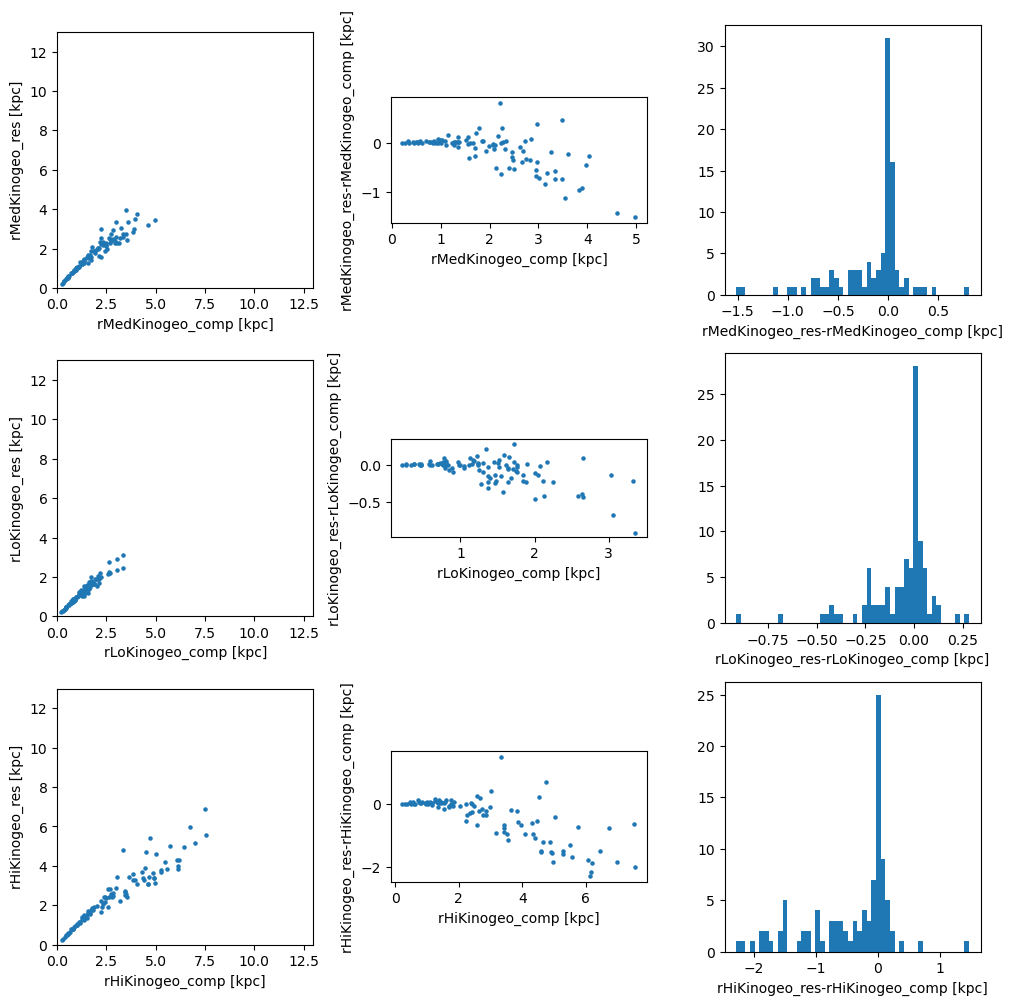

In [29]:
# plot comparison plots of Kinegeo distance estimation

# read in csv with own results
results = np.loadtxt('./results/results.csv', delimiter=',',skiprows=1)

fig,ax = plt.subplots(3,3,figsize=(10,10))

# plot  comparison, _res indicates the results from this notebook, _comp indicates comparison data 

# rMedKinogeo

ax[0,0].scatter(comp_data[:,4]/1e3, results[:,4],s=5)
ax[0,0].set_ylabel('rMedKinogeo_res [kpc]')
ax[0,0].set_xlabel('rMedKinogeo_comp [kpc]')
ax[0,0].set_aspect('equal')
ax[0,0].set_ylim(0,13)
ax[0,0].set_xlim(0,13)

ax[0,1].scatter(comp_data[:,4]/1e3, results[:,4]-comp_data[:,4]/1e3,s=5)
ax[0,1].set_ylabel('rMedKinogeo_res-rMedKinogeo_comp [kpc]')
ax[0,1].set_xlabel('rMedKinogeo_comp [kpc]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(results[:,4]-comp_data[:,4]/1e3,bins=50)
ax[0,2].set_xlabel('rMedKinogeo_res-rMedKinogeo_comp [kpc]')


#rLoKinogeo

ax[1,0].scatter(comp_data[:,5]/1e3 ,results[:,5],s=5)
ax[1,0].set_ylabel('rLoKinogeo_res [kpc]')
ax[1,0].set_xlabel('rLoKinogeo_comp [kpc]')
ax[1,0].set_aspect('equal')
ax[1,0].set_ylim(0,13)
ax[1,0].set_xlim(0,13)

ax[1,1].scatter(comp_data[:,5]/1e3, results[:,5]-comp_data[:,5]/1e3,s=5)
ax[1,1].set_ylabel('rLoKinogeo_res-rLoKinogeo_comp [kpc]')
ax[1,1].set_xlabel('rLoKinogeo_comp [kpc]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(results[:,5]-comp_data[:,5]/1e3,bins=50)
ax[1,2].set_xlabel('rLoKinogeo_res-rLoKinogeo_comp [kpc]')



#rHiKinogeo

ax[2,0].scatter(comp_data[:,6]/1e3, results[:,6],s=5)
ax[2,0].set_ylabel('rHiKinogeo_res [kpc]')
ax[2,0].set_xlabel('rHiKinogeo_comp [kpc]')
ax[2,0].set_aspect('equal')
ax[2,0].set_ylim(0,13)
ax[2,0].set_xlim(0,13)

ax[2,1].scatter(comp_data[:,6]/1e3, results[:,6]-comp_data[:,6]/1e3,s=5)
ax[2,1].set_ylabel('rHiKinogeo_res-rHiKinogeo_comp [kpc]')
ax[2,1].set_xlabel('rHiKinogeo_comp [kpc]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(results[:,6]-comp_data[:,6]/1e3,bins=50)
ax[2,2].set_xlabel('rHiKinogeo_res-rHiKinogeo_comp [kpc]')


plt.tight_layout()

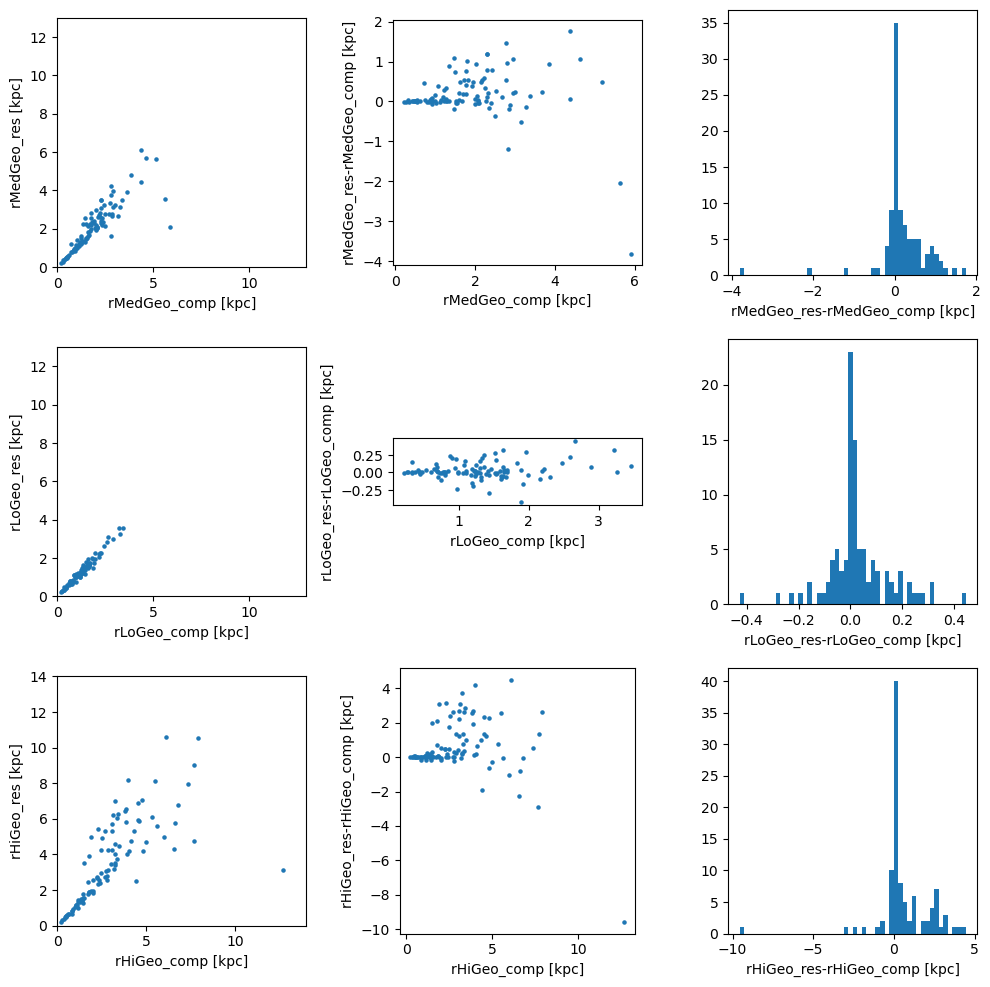

In [30]:
# plot comparison plots of Geo distance estimation

fig,ax = plt.subplots(3,3,figsize=(10,10))

# plot  comparison, _res indicates the results from this notebook, _comp indicates comparison data 

# rMedGeo

ax[0,0].scatter(comp_data[:,1]/1e3, results[:,1],s=5)
ax[0,0].set_ylabel('rMedGeo_res [kpc]')
ax[0,0].set_xlabel('rMedGeo_comp [kpc]')
ax[0,0].set_aspect('equal')
ax[0,0].set_ylim(0,13)
ax[0,0].set_xlim(0,13)

ax[0,1].scatter(comp_data[:,1]/1e3, results[:,1]-comp_data[:,1]/1e3,s=5)
ax[0,1].set_ylabel('rMedGeo_res-rMedGeo_comp [kpc]')
ax[0,1].set_xlabel('rMedGeo_comp [kpc]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(results[:,1]-comp_data[:,1]/1e3,bins=50)
ax[0,2].set_xlabel('rMedGeo_res-rMedGeo_comp [kpc]')



#rLoKinogeo

ax[1,0].scatter(comp_data[:,2]/1e3 ,results[:,2],s=5)
ax[1,0].set_ylabel('rLoGeo_res [kpc]')
ax[1,0].set_xlabel('rLoGeo_comp [kpc]')
ax[1,0].set_aspect('equal')
ax[1,0].set_ylim(0,13)
ax[1,0].set_xlim(0,13)

ax[1,1].scatter(comp_data[:,2]/1e3, results[:,2]-comp_data[:,2]/1e3,s=5)
ax[1,1].set_ylabel('rLoGeo_res-rLoGeo_comp [kpc]')
ax[1,1].set_xlabel('rLoGeo_comp [kpc]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(results[:,2]-comp_data[:,2]/1e3,bins=50)
ax[1,2].set_xlabel('rLoGeo_res-rLoGeo_comp [kpc]')



#rHiKinogeo

ax[2,0].scatter(comp_data[:,3]/1e3, results[:,3],s=5)
ax[2,0].set_ylabel('rHiGeo_res [kpc]')
ax[2,0].set_xlabel('rHiGeo_comp [kpc]')
ax[2,0].set_aspect('equal')
ax[2,0].set_ylim(0,14)
ax[2,0].set_xlim(0,14)

ax[2,1].scatter(comp_data[:,3]/1e3, results[:,3]-comp_data[:,3]/1e3,s=5)
ax[2,1].set_ylabel('rHiGeo_res-rHiGeo_comp [kpc]')
ax[2,1].set_xlabel('rHiGeo_comp [kpc]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(results[:,3]-comp_data[:,3]/1e3,bins=50)
ax[2,2].set_xlabel('rHiGeo_res-rHiGeo_comp [kpc]')


plt.tight_layout()

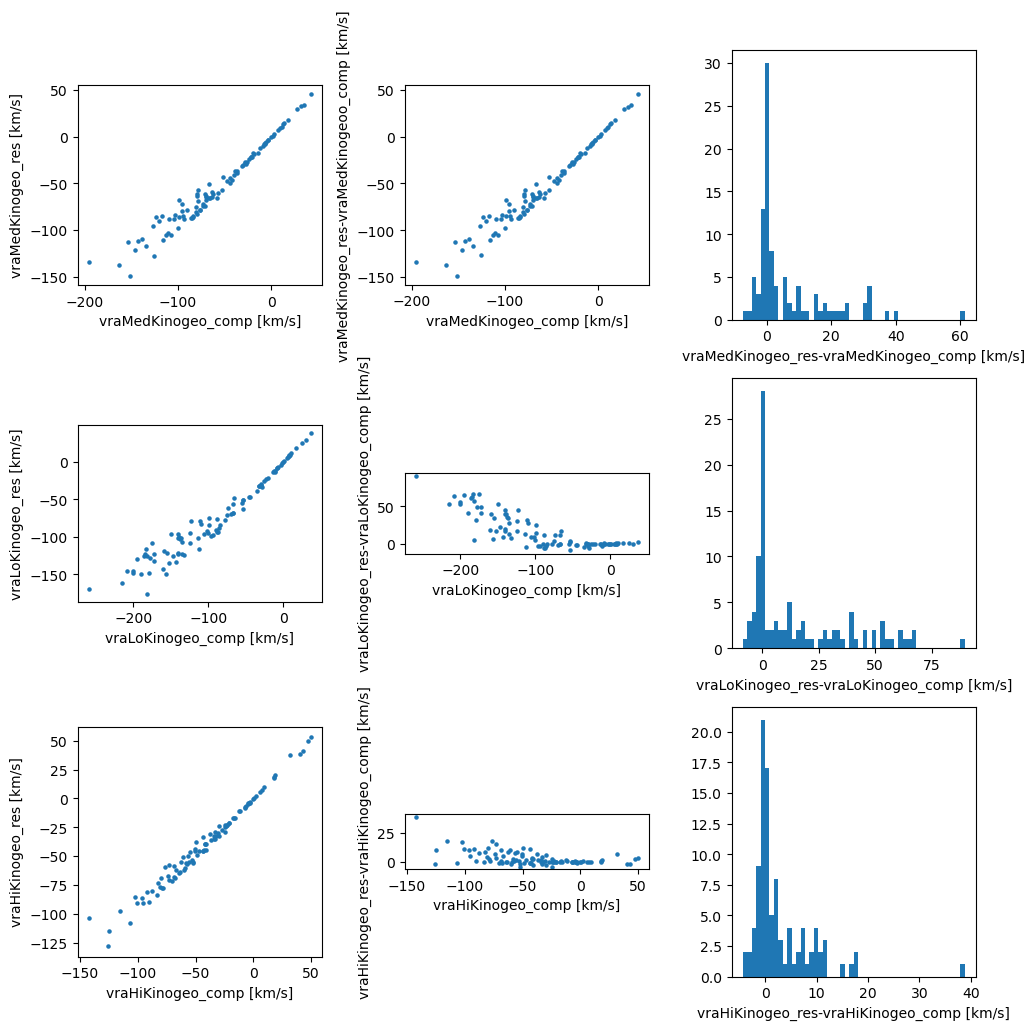

In [31]:
# comparison plots for velocity estimation (ra)

fig,ax = plt.subplots(3,3,figsize=(10,10))

# plot  comparison, _res indicates the results from this notebook, _comp indicates comparison data 

# vraMedKinogeo

ax[0,0].scatter(comp_data[:,7], results[:,7],s=5)
ax[0,0].set_ylabel('vraMedKinogeo_res [km/s]')
ax[0,0].set_xlabel('vraMedKinogeo_comp [km/s]')
ax[0,0].set_aspect('equal')

ax[0,1].scatter(comp_data[:,7], results[:,7]-comp_data[:,7]/1e3,s=5)
ax[0,1].set_ylabel('vraMedKinogeo_res-vraMedKinogeoo_comp [km/s]')
ax[0,1].set_xlabel('vraMedKinogeo_comp [km/s]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(results[:,7]-comp_data[:,7],bins=50)
ax[0,2].set_xlabel('vraMedKinogeo_res-vraMedKinogeo_comp [km/s]')



# vraLoKinogeo

ax[1,0].scatter(comp_data[:,8],results[:,8],s=5)
ax[1,0].set_ylabel('vraLoKinogeo_res [km/s]')
ax[1,0].set_xlabel('vraLoKinogeo_comp [km/s]')
ax[1,0].set_aspect('equal')

ax[1,1].scatter(comp_data[:,8], results[:,8]-comp_data[:,8],s=5)
ax[1,1].set_ylabel('vraLoKinogeo_res-vraLoKinogeo_comp [km/s]')
ax[1,1].set_xlabel('vraLoKinogeo_comp [km/s]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(results[:,8]-comp_data[:,8],bins=50)
ax[1,2].set_xlabel('vraLoKinogeo_res-vraLoKinogeo_comp [km/s]')



# vraHiKinogeo

ax[2,0].scatter(comp_data[:,9], results[:,9],s=5)
ax[2,0].set_ylabel('vraHiKinogeo_res [km/s]')
ax[2,0].set_xlabel('vraHiKinogeo_comp [km/s]')
ax[2,0].set_aspect('equal')

ax[2,1].scatter(comp_data[:,9], results[:,9]-comp_data[:,9],s=5)
ax[2,1].set_ylabel('vraHiKinogeo_res-vraHiKinogeo_comp [km/s]')
ax[2,1].set_xlabel('vraHiKinogeo_comp [km/s]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(results[:,9]-comp_data[:,9],bins=50)
ax[2,2].set_xlabel('vraHiKinogeo_res-vraHiKinogeo_comp [km/s]')


plt.tight_layout()

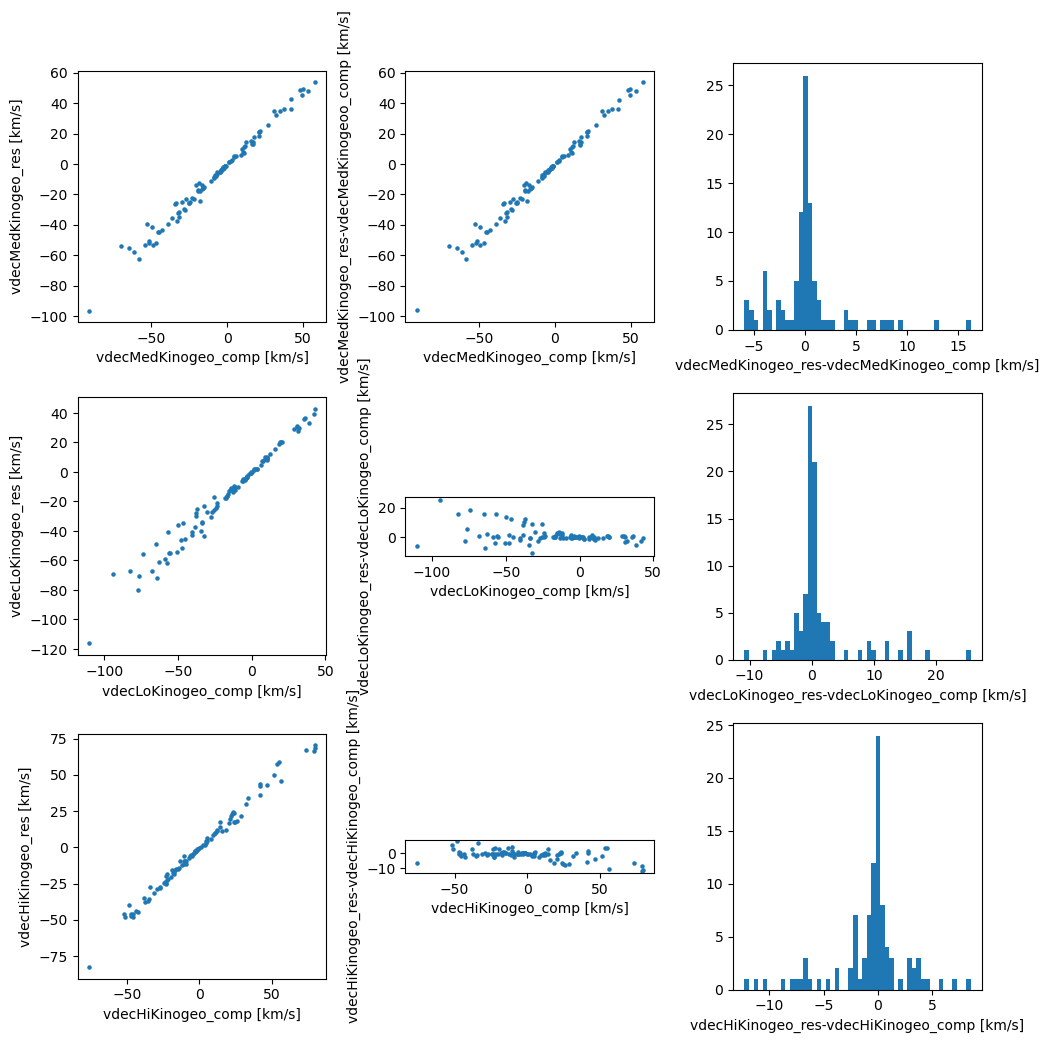

In [32]:
# comparison plots for velocity estimation (dec)

fig,ax = plt.subplots(3,3,figsize=(10,10))

# plot  comparison, _res indicates the results from this notebook, _comp indicates comparison data 

# vdecMedKinogeo

ax[0,0].scatter(comp_data[:,10], results[:,10],s=5)
ax[0,0].set_ylabel('vdecMedKinogeo_res [km/s]')
ax[0,0].set_xlabel('vdecMedKinogeo_comp [km/s]')
ax[0,0].set_aspect('equal')

ax[0,1].scatter(comp_data[:,10], results[:,10]-comp_data[:,10]/1e3,s=5)
ax[0,1].set_ylabel('vdecMedKinogeo_res-vdecMedKinogeoo_comp [km/s]')
ax[0,1].set_xlabel('vdecMedKinogeo_comp [km/s]')
ax[0,1].set_aspect('equal')

ax[0,2].hist(results[:,10]-comp_data[:,10],bins=50)
ax[0,2].set_xlabel('vdecMedKinogeo_res-vdecMedKinogeo_comp [km/s]')



# vraLoKinogeo

ax[1,0].scatter(comp_data[:,11],results[:,11],s=5)
ax[1,0].set_ylabel('vdecLoKinogeo_res [km/s]')
ax[1,0].set_xlabel('vdecLoKinogeo_comp [km/s]')
ax[1,0].set_aspect('equal')

ax[1,1].scatter(comp_data[:,11], results[:,11]-comp_data[:,11],s=5)
ax[1,1].set_ylabel('vdecLoKinogeo_res-vdecLoKinogeo_comp [km/s]')
ax[1,1].set_xlabel('vdecLoKinogeo_comp [km/s]')
ax[1,1].set_aspect('equal')

ax[1,2].hist(results[:,11]-comp_data[:,11],bins=50)
ax[1,2].set_xlabel('vdecLoKinogeo_res-vdecLoKinogeo_comp [km/s]')



# vraHiKinogeo

ax[2,0].scatter(comp_data[:,12], results[:,12],s=5)
ax[2,0].set_ylabel('vdecHiKinogeo_res [km/s]')
ax[2,0].set_xlabel('vdecHiKinogeo_comp [km/s]')
ax[2,0].set_aspect('equal')

ax[2,1].scatter(comp_data[:,12], results[:,12]-comp_data[:,12],s=5)
ax[2,1].set_ylabel('vdecHiKinogeo_res-vdecHiKinogeo_comp [km/s]')
ax[2,1].set_xlabel('vdecHiKinogeo_comp [km/s]')
ax[2,1].set_aspect('equal')

ax[2,2].hist(results[:,12]-comp_data[:,12],bins=50)
ax[2,2].set_xlabel('vdecHiKinogeo_res-vdecHiKinogeo_comp [km/s]')


plt.tight_layout()

### 2. Compare samples of 10 stars of hp 6200

In [21]:
# Read in comparison data:

# array containing source_ids 
id_distvel_6200_10 = np.genfromtxt("./results_est_distvel/distvel_files/distvel_6200.csv", delimiter=',', skip_header=1,  dtype='int64', usecols=0)
# array containig all data (dont use source_id from this, because its rounded, instead use array above)
data_distvel_6200_10 =  np.genfromtxt('./results_est_distvel/distvel_files/distvel_6200.csv', delimiter=',', skip_header=1,  dtype='float64')

# remove all rows containing nan: 
comp_data_10 = data_distvel_6200_10[~np.isnan(data_distvel_6200_10).any(axis=1), :]
comp_source_ids_10 = id_distvel_6200_10[~np.isnan(data_distvel_6200_10).any(axis=1)]

#extract data from Gaia 

source_ids_string_10 = ", ".join(map(str, comp_source_ids_10))
job_10 = Gaia.launch_job("select "
                                            "source_id, parallax, parallax_error,phot_g_mean_mag,\
                                            nu_eff_used_in_astrometry, pseudocolour,\
                                            ecl_lat, astrometric_params_solved,bp_rp,\
                                            pmra,pmra_error,pmdec, pmdec_error,parallax_pmra_corr,\
                                            parallax_pmdec_corr,pmra_pmdec_corr "
                                            "from gaiadr3.gaia_source "
                                            "where source_id in ({})".format(source_ids_string_10))
r_10 = job_10.get_results()



In [22]:
# sample posterior for each source 

rows_prior_summary = np.loadtxt('prior_summary.csv', delimiter=',',skiprows=1)

rSamples_kinegeo_10 = []
rSamples_geo_10 = []

Nsamp= 500
Nburnin= 50
    
for i in range(len(comp_source_ids_10)): 

    w = float(r_10['parallax'][i])
    sd_w = float(r_10['parallax_error'][i])   
    
    mu_ra = float(r_10['pmra'][i])
    mu_dec = float(r_10['pmdec'][i])
    sd_mu_ra = float(r_10['pmra_error'][i])
    sd_mu_dec = float(r_10['pmdec_error'][i])
    corr_w_mu_ra = float(r_10['parallax_pmra_corr'][i])
    corr_w_mu_dec = float(r_10['parallax_pmdec_corr'][i])
    corr_mu_ra_dec = float(r_10['pmra_pmdec_corr'][i])
    
    phot_g_mean_mag = float(r_10['phot_g_mean_mag'][i])
    nu_eff_used_in_astrometry = float(r_10['nu_eff_used_in_astrometry'][i])
    pseudocolour = float(r_10['pseudocolour'][i])
    ecl_lat = float(r_10['ecl_lat'][i])
    astrometric_params_solved = float(r_10['astrometric_params_solved'][i])
    
    
    source_id = int(r_10['source_id'][i])
    print(source_id)
    healpix = math.floor(source_id / (2**(35)*4**(12-5)) )
    
    # zeropoint correction
    if astrometric_params_solved == 31 or astrometric_params_solved == 95:    
        if  phot_g_mean_mag == np.nan:
            wzp = -0.017                    
        else:
             wzp = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)             
    else: 
        wzp = 0
    
    parallax = w - wzp
    parallaxVar = sd_w**2
    propm = np.array([mu_ra,mu_dec])
    
    Cov3 = np.array([[sd_w**2, sd_w*sd_mu_ra*corr_w_mu_ra, sd_w*sd_mu_dec*corr_w_mu_dec],
                     [sd_w*sd_mu_ra*corr_w_mu_ra, sd_mu_ra**2, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec],
                     [sd_w*sd_mu_dec*corr_w_mu_dec, sd_mu_ra*sd_mu_dec*corr_mu_ra_dec, sd_mu_dec**2]])
    
    
    Sigma_w_w = Cov3[0,0]
    Sigma_mu_w = np.array([Cov3[1,0],Cov3[2,0]])
    Sigma_w_mu = np.transpose(Sigma_mu_w) #np.array([Cov3[0,1],Cov3[0,2]])
    Sigma_mu_mu = np.array([[Cov3[1,1],Cov3[1,2]],
                           [Cov3[2,1],Cov3[2,2]]])
    
    
    
    Cov2 = Sigma_mu_mu - np.outer(Sigma_mu_w, Sigma_w_w**(-1)*Sigma_w_mu)
    
    
    alpha = float(rows_prior_summary[healpix][6])
    beta = float(rows_prior_summary[healpix][7])
    rlen = float(rows_prior_summary[healpix][5])
    rlen_EDSD = float(rows_prior_summary[healpix][10])
    
    rInit = float(mode_post3(w=1e-3*parallax,wsd=1e-3*sd_w,rlen = rlen_EDSD,retall = False))*1e-3 
    rStep = 0.75*rInit*min(1/3, abs(sd_w/parallax))
    
    # using metrop.py------------------------------------------------------------------------------------------------------------------------------
    
    #kinegeometric samples
    samp_kinegeo = metrop(func=logkinegeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2, seed=seed,\
                          parallax=parallax, parallaxVar = parallaxVar,propm=propm, Cov3=Cov3, Cov2=Cov2, healpix=healpix, alpha=alpha,beta=beta,rlen=rlen,kfac=kfac)
    
    rSamp_kinegeo = samp_kinegeo[:,1]
    
    
    #geometric samples
    samp_geo = metrop(func=loggeopostdensity ,thetaInit= rInit ,Nburnin=Nburnin ,Nsamp=Nsamp,sampleCov=rStep**2 ,seed=seed,\
                      parallax=parallax, parallaxVar = parallaxVar,alpha=alpha,beta=beta,rlen=rlen)
    
    rSamp_geo = samp_geo[:,1]
    
    
    rSamples_kinegeo_10.append(rSamp_kinegeo)
    rSamples_geo_10.append(rSamp_geo)
    
# save to csv file; all samples for one source_id are in one row, same order as input 

np.savetxt('./results/rSamples_kinegeo_10.csv', rSamples_kinegeo_10, delimiter=",")
np.savetxt('./results/rSamples_geo_10.csv', rSamples_geo_10, delimiter=",")

/tmp/ipykernel_3664259/1839876657.py:26: UserWarning: Warning: converting a masked element to nan.
  pseudocolour = float(r_10['pseudocolour'][i])


3490289711213205632
3490289715508854016
3490289749867760896


/tmp/ipykernel_3664259/2849474582.py:31: RuntimeWarning: invalid value encountered in log
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_3664259/2849474582.py:31: RuntimeWarning: invalid value encountered in power
  logPrior = -loggamma((beta+1)/alpha) + np.log(alpha) - (beta+1)*np.log(rlen) + beta*np.log(dist) - (dist/rlen)**alpha
/tmp/ipykernel_3664259/1839876657.py:25: UserWarning: Warning: converting a masked element to nan.
  nu_eff_used_in_astrometry = float(r_10['nu_eff_used_in_astrometry'][i])


3490289814292421888
3490289818586888576
3490289852947807744
3490289883011898496
3490289887307937920
3490289921667284352
3490289956027023232


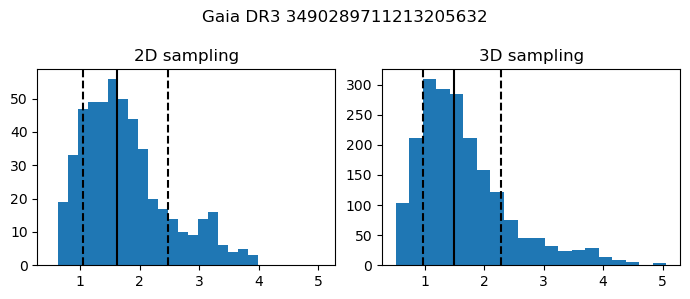

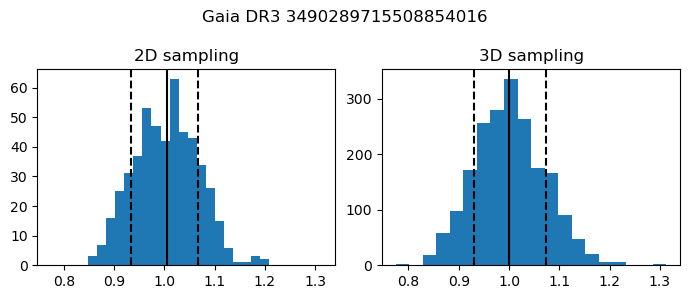

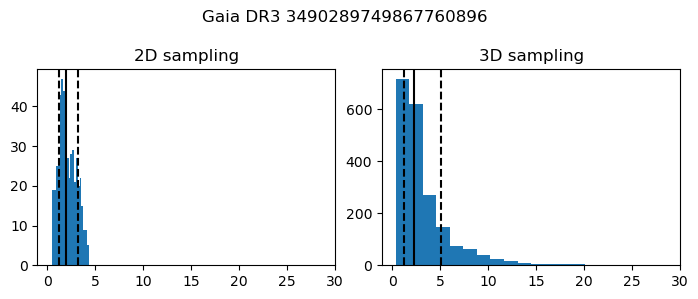

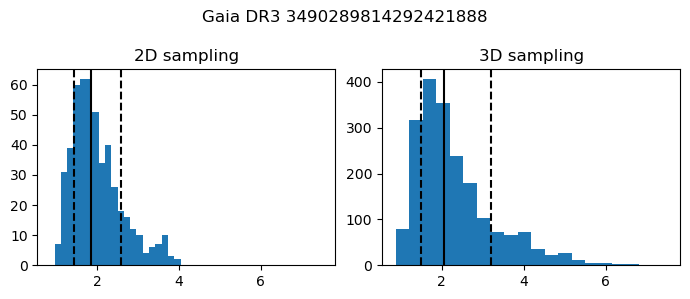

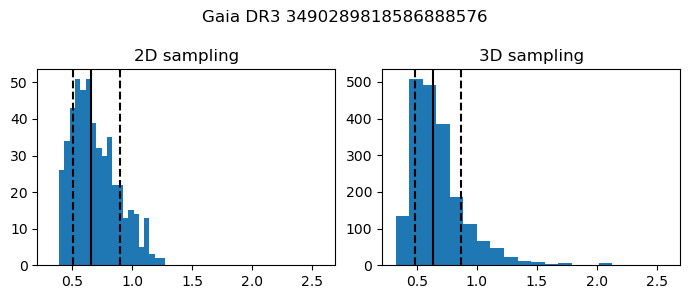

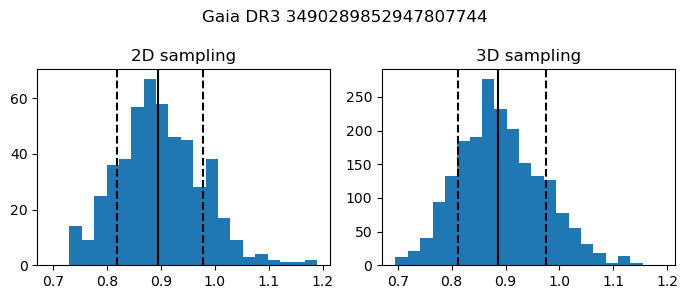

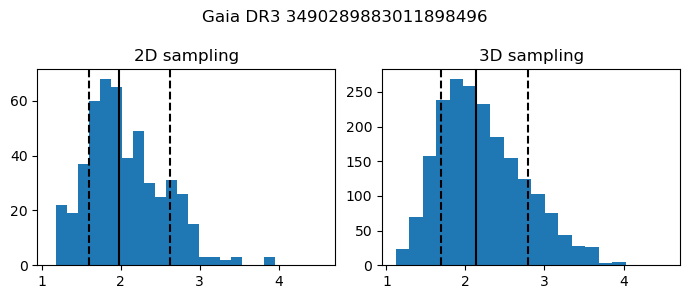

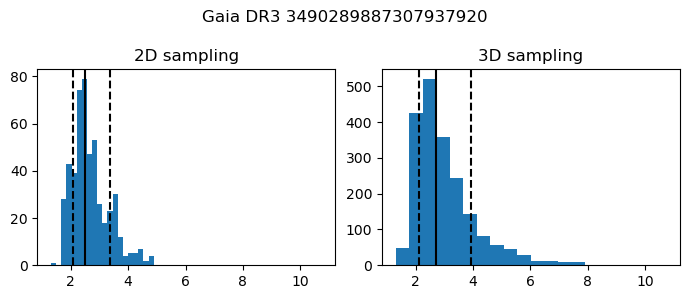

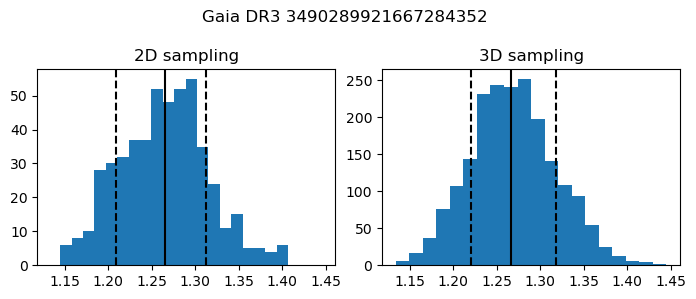

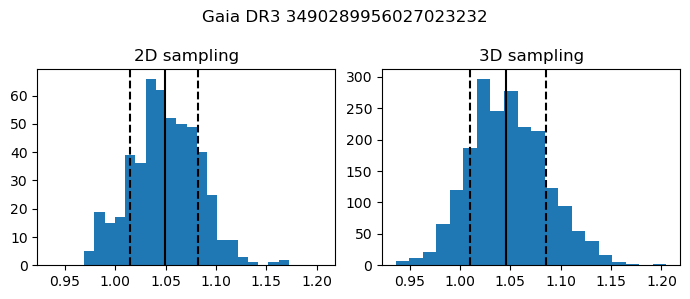

In [23]:
# plot samples

# load saved 2D samples
rSamples_kinegeo_10 = np.loadtxt('./results/rSamples_kinegeo_10.csv', delimiter=',')


for i in range(len(comp_source_ids_10)):
    
    # Create a new figure for each iteration
    
    fig,ax = plt.subplots(1,2,figsize=(7,3),sharex=True)
    ax[0].hist(rSamples_kinegeo_10[i],bins=20)
    plt.suptitle(f"Gaia DR3 {comp_source_ids_10[i]}")
    ax[0].set_title(f"2D sampling")
    plt.tight_layout()
    
    rQuantKinegeo = np.quantile(rSamples_kinegeo_10[i],probs)
    
    rMedKinegeo = rQuantKinegeo[0]
    rLoKinegeo = rQuantKinegeo[1]
    rHiKinegeo= rQuantKinegeo[2]
    
    ax[0].axvline(rMedKinegeo,color='black') 
    ax[0].axvline(rLoKinegeo,linestyle='--',color = 'black') 
    ax[0].axvline(rHiKinegeo,linestyle='--',color = 'black') 
    
    # load compasion samples 
    
    comp_samples_kinegeo_10 = np.loadtxt(f'./results_est_distvel/posterior_samples/kinogeosamples_6200_{comp_source_ids_10[i]}.csv', delimiter=',',skiprows=1)
    comp_rSamp_kinegeo_10 = comp_samples_kinegeo_10[:,0]
    ax[1].hist(comp_rSamp_kinegeo_10/1e3,bins=20)
    ax[1].set_title(f"3D sampling")
    
    ax[1].axvline(comp_data_10[i][4]/1e3 ,color='black') 
    ax[1].axvline(comp_data_10[i][5]/1e3, linestyle='--',color = 'black') 
    ax[1].axvline(comp_data_10[i][6]/1e3,linestyle='--',color = 'black') 